In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import os

# Precinct Shapefile

## VEST's Documentation File

Election results from Kansas Secretary of State (https://sos.ks.gov/elections/elections-statistics.html).
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

Shapefiles from county elections officials used in Geary, Johnson, Riley, and Sedgwick Counties.

Modifications needed to be made to reflect differences between Census shapefiles and actual PDF maps or reported results.

- Barber: Ridge merged into Sharon Township
- Butler: Augusta Township merged
- Chase: East/West Strong merged, East/West Falls merged
- Cherokee: Treece merged with township
- Clay: Altered Clay Center boundaries based on PDF map
- Cowley: Merge East/West Bolton
- Douglas: Altered based on PDF map
- Ellis: Split two precincts based on state house districts
- Franklin: Merged Ottawa 4+5, altered boundary between 1 and 2
- Hamilton: Adjusted Syracuse boundaries based on county commission district map
- Harvey: Distributed an exclave district to its neighboring townships
- Labette: Split precincts based on legislative districts
- Leavenworth: Merged legislative district-split precincts that don't appear in results
- Lyon: Mergers based on PDF map
- Meade: Split Louisburg based on PDF map
- Mitchell: Merged Beloit precincts based on county reports
- Osborne: Merged some cities into surrounding townships, split Ross based on information from personal communication with county election official
- Reno: Merged based on PDF map
- Shawnee: Merged wards in Topeka to match result reporting
- Stevens: Cut Moscow City out of Township using Census place shapefile, recut Hugoton based on PDF map
- Sumner: Split precincts based on legislative district lines


- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)


- G20USSDBOL - Barbara Bollier (Democratic Party)
- G20USSRMAR - Roger Marshall (Republican Party)
- G20USSLBUC - Jason Buckley (Libertarian Party)


## Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/ks_2020/ks_2020.shp")

In [3]:
vest_shp.shape

(4070, 10)

In [4]:
vest_shp.head(1)

,COUNTYFP,VTDST,NAMELSAD,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDBOL,G20USSRMAR,G20USSLBUC,geometry
0,001,000010,Carlyle Township Voting District,32,134,4,35,133,2,"POLYGON Z ((-95.42748 37.96487 0.00000, -95.42..."


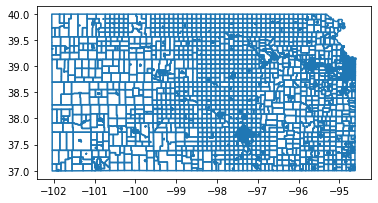

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp[vest_shp['COUNTYFP'] == '173']

,COUNTYFP,VTDST,NAMELSAD,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDBOL,G20USSRMAR,G20USSLBUC,geometry
3621,173,100000,101,601,488,33,595,458,64,"POLYGON Z ((-97.29881 37.66457 0.00000, -97.30..."
3622,173,100001,102,496,444,25,510,434,29,"POLYGON Z ((-97.26609 37.68854 0.00000, -97.26..."
3623,173,100002,103,141,62,4,135,61,8,"POLYGON Z ((-97.32639 37.67871 0.00000, -97.32..."
3624,173,100003,104,45,21,3,48,18,2,"POLYGON Z ((-97.31721 37.67876 0.00000, -97.31..."
3625,173,100004,105,456,212,17,462,190,37,"POLYGON Z ((-97.29890 37.67930 0.00000, -97.29..."
...,...,...,...,...,...,...,...,...,...,...
4065,173,100444,WA08,0,0,0,0,0,0,"POLYGON Z ((-97.38730 37.62487 0.00000, -97.38..."
4066,173,100445,WA09,0,0,0,0,0,0,"POLYGON Z ((-97.46341 37.63383 0.00000, -97.46..."
4067,173,100446,WA10,0,0,0,0,0,0,"POLYGON Z ((-97.46331 37.64772 0.00000, -97.46..."
4068,173,100447,WA11,0,0,0,0,0,0,"POLYGON Z ((-97.48022 37.63013 0.00000, -97.48..."


# Loading, Combining Election Results

## Load County Fips File

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Kansas"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

The `-edited.xlsx` files below were edited to combine the separate Excel tabs for Johnson, Sedgwick, Shawnee and Wyandotte counties into one tab. 

### Presidential

In [ ]:
pres_results = pd.ExcelFile('./raw-from-source/SOS/2020_General_Election_President_results_by_precinct-edited.xlsx')

minor_counties_df = pd.read_excel(pres_results, 'President')
minor_counties_df = minor_counties_df.pivot_table(index = ['County','Precinct','VTD'],
                         columns = ['Race','Candidate'],
                        values = ['Votes'],
                         aggfunc = 'sum')
minor_counties_df.reset_index(inplace=True)
minor_counties_df.head(1)

In [9]:
minor_counties_df.columns = ['county','precinct','vtd','G20PRERTRU','G20PRELJOR','G20PREDBID']
minor_counties_df

,county,precinct,vtd,G20PRERTRU,G20PRELJOR,G20PREDBID
0,Allen,Carlyle Township,000010,134.0,4.0,32.0
1,Allen,Cottage Grove Township,000020,101.0,2.0,18.0
2,Allen,Deer Creek Township,000030,60.0,1.0,11.0
3,Allen,East Elm,000040,237.0,2.0,45.0
4,Allen,Geneva Township,000050,65.0,0.0,12.0
...,...,...,...,...,...,...
2750,Woodson,Toronto Township,000070,189.0,9.0,58.0
2751,Woodson,Yates Center Ward 1,00008A,249.0,9.0,68.0
2752,Woodson,Yates Center Ward 1 Exclave,00008B,0.0,0.0,0.0
2753,Woodson,Yates Center Ward 2,000090,231.0,1.0,61.0


In [10]:
major_counties_df = pd.read_excel(pres_results, 'Other Counties')
major_counties_df.head()

,county,precinct,vtd,G20PREDBID,G20PRELJOR,G20PRERTRU
0,Johnson,Aubry Township Precinct 01,1,43,2,99
1,Johnson,Aubry Township Precinct 02,2,381,34,589
2,Johnson,Aubry Township Precinct 03,3,182,14,338
3,Johnson,Aubry Township Precinct 04,4,468,32,852
4,Johnson,Aubry Township Precinct 05,5,7,0,11


In [11]:
pres_results = pd.concat([minor_counties_df, major_counties_df], axis = 0, ignore_index = True)
pres_results.head()

,county,precinct,vtd,G20PRERTRU,G20PRELJOR,G20PREDBID
0,Allen,Carlyle Township,000010,134.0,4.0,32.0
1,Allen,Cottage Grove Township,000020,101.0,2.0,18.0
2,Allen,Deer Creek Township,000030,60.0,1.0,11.0
3,Allen,East Elm,000040,237.0,2.0,45.0
4,Allen,Geneva Township,000050,65.0,0.0,12.0


In [12]:
pres_results.shape

(3867, 6)

### Senate

In [13]:
senate_results = pd.ExcelFile('./raw-from-source/SOS/2020_General_Election_US_Senate_results_by_precinct-edited.xlsx')

minor_counties_df = pd.read_excel(senate_results, 'U.S. Senate')
minor_counties_df = minor_counties_df.pivot_table(index = ['County','Precinct','VTD'],
                         columns = ['Race','Candidate'],
                        values = ['Votes'],
                         aggfunc = 'sum')
minor_counties_df.reset_index(inplace=True)
minor_counties_df.head(1)

County          Precinct     VTD                Votes  \
Race                                       United States Senate   
Candidate                                      Bollier, Barbara   
0          Allen  Carlyle Township  000010                 35.0   

                                          
Race                                      
Candidate Buckley, Jason Marshall, Roger  
0                    2.0           133.0

In [14]:
minor_counties_df.columns = ['county','precinct','vtd','G20USSDBOL','G20USSLBUC','G20USSRMAR']
minor_counties_df

,county,precinct,vtd,G20USSDBOL,G20USSLBUC,G20USSRMAR
0,Allen,Carlyle Township,000010,35.0,2.0,133.0
1,Allen,Cottage Grove Township,000020,25.0,6.0,89.0
2,Allen,Deer Creek Township,000030,11.0,2.0,56.0
3,Allen,East Elm,000040,50.0,26.0,204.0
4,Allen,Geneva Township,000050,13.0,1.0,61.0
...,...,...,...,...,...,...
2750,Woodson,Toronto Township,000070,71.0,17.0,168.0
2751,Woodson,Yates Center Ward 1,00008A,78.0,37.0,206.0
2752,Woodson,Yates Center Ward 1 Exclave,00008B,0.0,0.0,0.0
2753,Woodson,Yates Center Ward 2,000090,70.0,18.0,205.0


In [15]:
major_counties_df = pd.read_excel(senate_results, 'Other Counties')
major_counties_df.head()

,county,precinct,vtd,G20USSDBOL,G20USSLBUC,G20USSRMAR
0,Johnson,Aubry Township Precinct 01,1,42,6,97
1,Johnson,Aubry Township Precinct 02,2,377,44,579
2,Johnson,Aubry Township Precinct 03,3,180,35,315
3,Johnson,Aubry Township Precinct 04,4,473,66,812
4,Johnson,Aubry Township Precinct 05,5,7,0,10


In [16]:
senate_results = pd.concat([minor_counties_df, major_counties_df], axis = 0, ignore_index = True)
senate_results.head()

,county,precinct,vtd,G20USSDBOL,G20USSLBUC,G20USSRMAR
0,Allen,Carlyle Township,000010,35.0,2.0,133.0
1,Allen,Cottage Grove Township,000020,25.0,6.0,89.0
2,Allen,Deer Creek Township,000030,11.0,2.0,56.0
3,Allen,East Elm,000040,50.0,26.0,204.0
4,Allen,Geneva Township,000050,13.0,1.0,61.0


In [17]:
senate_results.shape

(3867, 6)

### Combine Results

In [18]:
election_results = pres_results.merge(senate_results, how = 'outer', on = ['county','precinct','vtd'])

In [19]:
election_results.head()

,county,precinct,vtd,G20PRERTRU,G20PRELJOR,G20PREDBID,G20USSDBOL,G20USSLBUC,G20USSRMAR
0,Allen,Carlyle Township,000010,134.0,4.0,32.0,35.0,2.0,133.0
1,Allen,Cottage Grove Township,000020,101.0,2.0,18.0,25.0,6.0,89.0
2,Allen,Deer Creek Township,000030,60.0,1.0,11.0,11.0,2.0,56.0
3,Allen,East Elm,000040,237.0,2.0,45.0,50.0,26.0,204.0
4,Allen,Geneva Township,000050,65.0,0.0,12.0,13.0,1.0,61.0


In [20]:
for c in [c for c in election_results.columns if 'G20' in c]:
    election_results[c] = election_results[c].astype(int)

In [21]:
election_results['COUNTYFP'] = election_results['county'].map(fips_dict)

In [22]:
election_results['COUNTYFP'].count()

3867

In [23]:
election_results.shape

(3867, 10)

In [24]:
vest_shp.shape

(4070, 10)

# Validating Election Results

## Statewide

In [25]:
election_results.columns

Index(['county', 'precinct', 'vtd', 'G20PRERTRU', 'G20PRELJOR', 'G20PREDBID',
       'G20USSDBOL', 'G20USSLBUC', 'G20USSRMAR', 'COUNTYFP'],
      dtype='object')

In [26]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))


data_columns = ['G20PREDBID', 'G20PRELJOR', 'G20PRERTRU',
       'G20USSDBOL', 'G20USSLBUC', 'G20USSRMAR']

statewide_totals_check(vest_shp, election_results, data_columns)


***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 570323
G20PRELJOR is equal 	VEST / RDH: 30574
G20PRERTRU is equal 	VEST / RDH: 771406
G20USSDBOL is equal 	VEST / RDH: 571530
G20USSLBUC is equal 	VEST / RDH: 68263
G20USSRMAR is equal 	VEST / RDH: 727962


These match the state's election results [here](https://sos.ks.gov/elections/20elec/2020_General_Official_Vote_Totals.pdf). 

## County-by-county

In [27]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

                    
county_totals_check(vest_shp,election_results,data_columns,'COUNTYFP')

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PRERTRU is equal across all counties
G20USSDBOL is equal across all counties
G20USSLBUC is equal across all counties
G20USSRMAR is equal across all counties


## Precinct-by-precinct

VEST performed the following merges and splits of precincts in order to join the files: 
```
- Barber: Ridge merged into Sharon Township
- Butler: Augusta Township merged
- Chase: East/West Strong merged, East/West Falls merged
- Cherokee: Treece merged with township
- Clay: Altered Clay Center boundaries based on PDF map
- Cowley: Merge East/West Bolton
- Douglas: Altered based on PDF map
- Ellis: Split two precincts based on state house districts
- Franklin: Merged Ottawa 4+5, altered boundary between 1 and 2
- Hamilton: Adjusted Syracuse boundaries based on county commission district map
- Harvey: Distributed an exclave district to its neighboring townships
- Labette: Split precincts based on legislative districts
- Leavenworth: Merged legislative district-split precincts that don't appear in results
- Lyon: Mergers based on PDF map
- Meade: Split Louisburg based on PDF map
- Mitchell: Merged Beloit precincts based on county reports
- Osborne: Merged some cities into surrounding townships, split Ross based on information from personal communication with county election official
- Reno: Merged based on PDF map
- Shawnee: Merged wards in Topeka to match result reporting
- Stevens: Cut Moscow City out of Township using Census place shapefile, recut Hugoton based on PDF map
- Sumner: Split precincts based on legislative district lines
```

We are not going to validate the precinct by precinct election results at this time, as there is a difference of 4,070 precincts in the VEST file and 3,867 in the sos election results, and the county by county election results match. 